
This notebook uses the output of the rule
--- 90_est_gaps.smk::merge_bubbles_node_infos
as input, and produces supplementary figures
illustrating PAR1 variation.

Execution directory:  /home/ebertp/work/code/marschall-lab/project-male-assembly/notebooks/plotting/par1_graphs
Working directory:  /home/ebertp/work/code/marschall-lab/project-male-assembly/notebooks/plotting/par1_graphs
Output directory:  /home/ebertp/work/projects/sig_chry/paper/output/figures
504615
504615


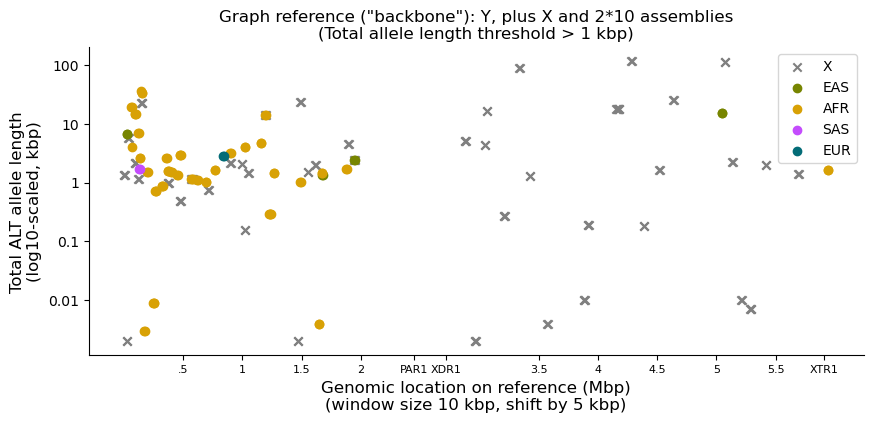

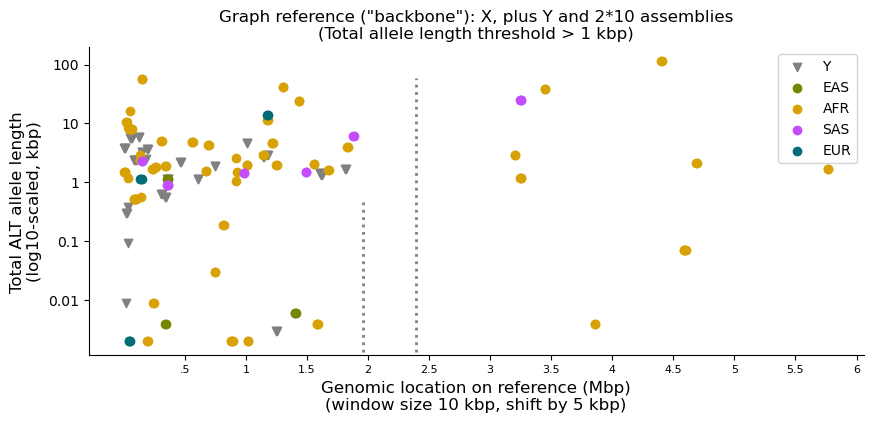

In [2]:
import pandas as pd
import numpy as np
import pathlib as pl
import collections as col

import matplotlib as mpl
import matplotlib.pyplot as plt

# required to have text output as "text fields"
# and not individual objects
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

save_plots = False

desc="""
This notebook uses the output of the rule
--- 90_est_gaps.smk::merge_bubbles_node_infos
as input, and produces supplementary figures
illustrating PAR1 variation.
"""

print(desc)

repo_dir = pl.Path('/home/ebertp/work/code/marschall-lab/project-male-assembly').resolve(strict=True)
exec_dir = pl.Path('.').resolve(strict=True)
wd_dir = exec_dir
out_dir = pl.Path('/home/ebertp/work/projects/sig_chry/paper/output/figures').resolve(strict=True)

print('Execution directory: ', exec_dir)
print('Working directory: ', wd_dir)
print('Output directory: ', out_dir)
print('=================================')

input_path = pl.Path("/home/ebertp/work/projects/sig_chry/paper/data/graphs")

color_lut = dict()

y_par1 = 2458321
y_xdr1 = 2726838
y_xtr1 = 5914797

BIN_SIZE = 10000
BIN_LABEL = int(BIN_SIZE / 1e3)
SHIFT_SIZE = 5000
SHIFT_LABEL = int(SHIFT_SIZE / 1e3)

def sort_by_backbone(file_path):
    
    if "chrYX" in file_path.name:
        return 0
    elif "chrXY" in file_path.name:
        return 1
    else:
        return 100

input_tables = sorted(input_path.glob("*flat-bubbles.tsv"), key=sort_by_backbone)

LAST_Y_VAR = 0
LAST_X_PAR = 0
DIST_TO_PAR = None

for table in input_tables:
    table_spec = table.name.split(".")
    backbone = table_spec[3]
    num_samples = int(table_spec[1].strip("samples"))
    size_t = int(table_spec[4].strip("Lkbp"))
    if size_t != 1:
        continue
    if num_samples != 10:
        continue
    if backbone in ["chrY", "chrYX"]:
        if backbone == "chrY":
            backbone = "Y"
            complement = None
        else:
            backbone = "Y"
            complement = "X"
    elif backbone in ["chrX", "chrXY"]:
        if backbone == "chrX":
            backbone = "X"
            complement = None
        else:
            backbone = "X"
            complement = "Y"
    else:
        raise ValueError(backbone)

    if complement is None:
        continue
    y_par1_set = False
    y_xdr1_set = False
    y_xtr1_set = False

    df = pd.read_csv(table, header=0, sep="\t")
    df = df.loc[(df["is_source"] == 0) & (df["is_sink"] == 0), :].copy()
    last_bubble = df.loc[df["start"] < 6e6, "bubble_num"].max()
    last_end = max(df.loc[df["bubble_num"] == last_bubble, "end"].max(), 6e6)
    df = df.loc[df["end"] < last_end + 1, :].copy()
    
    
    
    pop_variation = []
    
    x_ticks = []
    x_ticklabels = []
    x_par_tick = None
    x_var_tick = None
    for win_idx, start in enumerate(np.arange(0, last_end + 1, step=SHIFT_SIZE)):
        end = start + BIN_SIZE
        if int(start) in [500000, 1000000, 1500000, 2000000, 3500000, 4000000, 4500000, 5000000, 5500000]:
            x_ticks.append(win_idx)
            label = str(round(start/1e6, 1)).strip("0").rstrip(".")
            x_ticklabels.append(label)
        if backbone == "X":
            if int(start) in [2500000, 3000000, 6000000]:
                x_ticks.append(win_idx)
                label = str(round(start/1e6, 1)).strip("0").rstrip(".")
                x_ticklabels.append(label)
        if backbone == "Y":
            if (start < y_par1 < end) and not y_par1_set:
                x_ticks.append(win_idx)
                x_ticklabels.append("PAR1")
                y_par1_set = True
            if (start < y_xdr1 < end) and not y_xdr1_set:
                x_ticks.append(win_idx)
                x_ticklabels.append("XDR1")
                y_xdr1_set = True
            if (start < y_xtr1 < end) and not y_xtr1_set:
                x_ticks.append(win_idx)
                x_ticklabels.append("XTR1")
                y_xtr1_set = True
        
        window = (start < df["end"]) & (end > df["start"])
        win_variation = 0.
        pop_var = col.Counter()
        for bubble, nodes in df.loc[window, :].groupby("bubble_id"):
            total_allele_length = nodes["node_length"].sum()
            if total_allele_length < 1000:
                continue
            if (nodes["sample"] == "T2T.X").all() or (nodes["sample"] == "T2T.Y").all():
                # skip over bubbles that are all ref
                # probably something filtered after the
                # initial construction of the minigraph?
                continue
            last_end = nodes["end"].max()
            if backbone == "Y":
                if last_end < y_par1:
                    LAST_Y_VAR = max(last_end, LAST_Y_VAR)
            else:
                if last_end < int(2.5e6):
                    LAST_X_PAR = max(last_end, LAST_X_PAR)
            overlap = min(end, nodes["end"].unique()) - max(start, nodes["start"].unique())
            if overlap == 0:
                overlap = 1
            assert overlap > 0, f"{start} - {end} - {overlap} - {nodes}"
            win_variation += overlap
            for row in nodes.itertuples():
                if row.sample == "T2T." + backbone:
                    continue
                elif complement is not None and row.sample.endswith(complement):
                    pop_var["cmpl_abs"] += row.node_length
                    color_lut["cmpl"] = "#000000"
                else:
                    pop_var[row.super_pop + "_abs"] += row.node_length
                    color_lut[row.super_pop] = row.color
        pop_var["win_idx"] = win_idx
        pop_var["var_abs"] = win_variation
        pop_variation.append(pop_var)

    # record distance between last bubble and PAR1 in Y
    if backbone == "Y":
        DIST_TO_PAR = y_par1 - LAST_Y_VAR
    if backbone == "X":
        extrapol_par_boundary = LAST_X_PAR + DIST_TO_PAR
        x_par_tick = extrapol_par_boundary // 5000 + 1
        x_var_tick = LAST_Y_VAR // 5000 + 1
        
    if backbone == "X":
        assert x_par_tick is not None
        assert x_var_tick is not None
    
    print(DIST_TO_PAR)
    
    plot_df = pd.DataFrame.from_records(pop_variation, index="win_idx")
    plot_df.fillna(0, inplace=True)
    for column in plot_df.columns:
        if not column.endswith("abs"):
            continue
        new_col = column.replace("_abs", "_log")
        plot_df[new_col] = (plot_df[column] + 1).astype(float).apply(np.log10)
        
    fig, ax = plt.subplots(figsize=(10,4))
    
    #ax.scatter(
    #    plot_df.index,
    #    plot_df["var_log"],
    #    color="grey",
    #    label="(window variation)",
    #    ls="dotted"
    #)
    
    marker_style = "x" if complement == "X" else "v"
    try:
        nz_sub = plot_df["cmpl_log"] > 0
        ax.scatter(
            plot_df.index[nz_sub],
            plot_df.loc[nz_sub, "cmpl_log"],
            color="grey",
            label=complement,
            marker=marker_style
            
        )
    except KeyError:
        assert complement is None
        print("No homolog")
    
    for spop in color_lut.keys():
        if spop == "cmpl":
            continue
        try:
            nz_sub = plot_df[f"{spop}_log"] > 0
            ax.scatter(
                plot_df.index[nz_sub],
                plot_df.loc[nz_sub, f"{spop}_log"],
                color=color_lut[spop],
                label=spop,
                ls="solid"
            )
        except KeyError:
            continue
            
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_ticklabels, fontsize=8)
    
    ax.set_yticks([1, 2, 3, 4, 5])
    ax.set_yticklabels(["0.01", "0.1", "1", "10", "100"])
    
    ax.set_xlabel(
        (
            f"Genomic location on reference (Mbp)\n"
            f"(window size {BIN_LABEL} kbp, shift by {SHIFT_LABEL} kbp)"
        ),
        fontsize=12
    )
    ax.set_ylabel("Total ALT allele length\n(log10-scaled, kbp)", fontsize=12)
    
    if complement is None:
        ax.set_title(
            f'Graph reference ("backbone"): {backbone}, plus {num_samples} assemblies'
            f'\n(Total allele length threshold > {size_t} kbp)'
        )
    else:
        ax.set_title(
            f'Graph reference ("backbone"): {backbone}, plus {complement} and 2*{num_samples} assemblies'
            f'\n(Total allele length threshold > {size_t} kbp)'
        )
    
    if backbone == "X":
        ax.axvline(x_par_tick, 0.01, 0.9, ls="dotted", color="grey", lw=2)
        ax.axvline(x_var_tick, 0.01, 0.5, ls="dotted", color="grey", lw=2)
    
    ax.legend()
            
    if save_plots:
        out_base_name = f"FigSX_par1-var_ref-{backbone}_{num_samples}assm"
        plt.savefig(
            out_dir / pl.Path(out_base_name + '.pdf'),
            bbox_inches='tight',
            facecolor="w", transparent=None,
            #bbox_extra_artists=[cmap_legend]
        )
        plt.savefig(
            out_dir / pl.Path(out_base_name + '.png'),
            bbox_inches='tight',
            facecolor="w", transparent=None,
            #bbox_extra_artists=[cmap_legend],
            dpi=150
        )
    #plt.close()

    